### 17 VMAT cases analysis

#### Load python packages

In [23]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import pymedphys
from DataProcess import DATAPROCESS

In [24]:
CT_path = 'C:/GitFolder/RL-Application-in-TPS/AUTO-PLANNING/AutoTemplateTuning/projects/dose prediction/DATA'
DATA_path = 'C:/GitFolder/RL-Application-in-TPS/AUTO-PLANNING/AutoTemplateTuning/projects/sequencing prediction/DATA_/'

X = DATAPROCESS(CT_path,DATA_path)

####  MU density difference

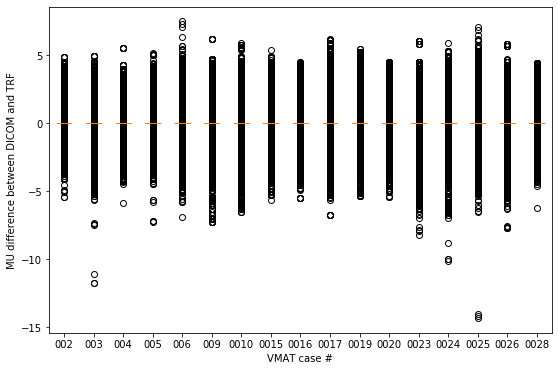

In [35]:
pt_id = ['002','003','004','005','006','009','0010','0015','0016','0017','0019','0020','0023','0024','0025','0026','0028']
DATA_path = 'C:/GitFolder/RL-Application-in-TPS/AUTO-PLANNING/AutoTemplateTuning/projects/sequencing prediction/DATA_/'
diff,diff_max,diff_var = [],[],[]
for item in pt_id:
    DICOM_MU = np.load(os.path.join(DATA_path,item + '_MU_density.npy'))
    TRF_MU = np.load(os.path.join(DATA_path,item + '_MU_density_trf.npy'))
    D = DICOM_MU - TRF_MU
    diff.append(D.flatten())
    diff_max.append(np.max(np.abs(D)))
    diff_var.append(np.std(np.abs(D)))

fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(diff,patch_artist=True)
ax.set_xticklabels(pt_id)
ax.set_xlabel('VMAT case #')
ax.set_ylabel('MU difference between DICOM and TRF')
plt.show()

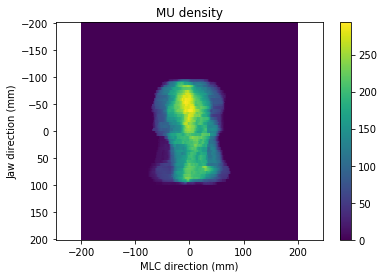

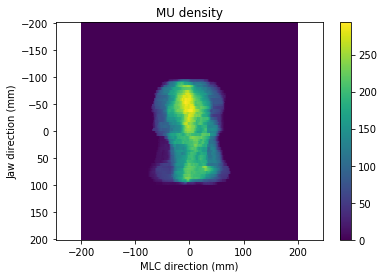

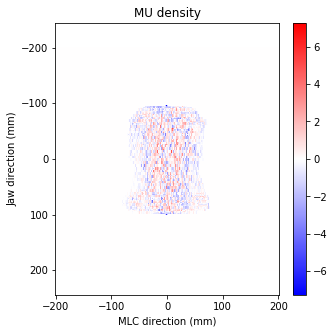

PLOT finished!


In [26]:
# show MU density of dicom, trf and difference
TRF_path = 'D:\\VM Settings\\XHTOMODATA RAW\\TRF\\005.trf'
DICOM_path = 'D:\\VM Settings\\XHTOMODATA RAW\\005\\005_VMATQATEST.dcm'
DICOM_MU_DENSITY = X.MU_Density_DICOM(DICOM_path) # DICOM path
# np.save(DATA_path + '005_MU_density.npy',DICOM_MU_DENSITY)
TRF_MU_DENSIT = X.MU_Density_TRF(TRF_path) # TRF path
# np.save(DATA_path + '005_MU_density_trf.npy',TRF_MU_DENSIT)
# display all
X.display_mu_density_and_difference()

### Calculate SSIM metrics for fluence map

In [109]:
import math
import numpy as np
import cv2

def ssim(img1, img2):
    C1 = (0.01 * np.max(img1))**2
    C2 = (0.03 * np.max(img2))**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map


def calculate_ssim(img1, img2):
    '''calculate SSIM
    the same outputs as MATLAB's
    img1, img2: [0, 255]
    '''
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')

In [110]:
import os
import numpy as np

SSIM, SSIM_mean = [],[]
path = 'C:\\GitFolder\\RL-Application-in-TPS\\AUTO-PLANNING\\AutoTemplateTuning\\projects\\sequencing prediction\\DATA_'
for item in pt_id:
    DICOM_MU_DENSITY = np.load(os.path.join(path,item+'_MU_density.npy'))
    TRF_MU_DENSIT = np.load(os.path.join(path,item+'_MU_density_trf.npy'))
    temp = calculate_ssim(DICOM_MU_DENSITY, TRF_MU_DENSIT)
    SSIM.append(temp)
    SSIM_mean.append(temp.mean())

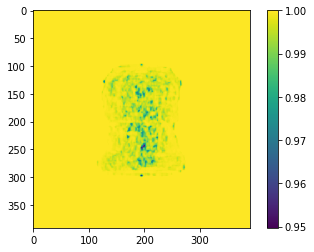

In [111]:
plt.imshow(SSIM[3])
plt.colorbar()

In [112]:
np.mean(SSIM_mean)

0.9988866733379272

### Calculate PSNR: Peak Signal-to-Noise Ratio

In [114]:
import math
import numpy as np

def calculate_psnr(img1, img2):
    # img1 and img2 have range [0, 255]
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(np.max(img1) / math.sqrt(mse))

In [115]:
PSNR, PSNR_mean = [],[]
path = 'C:\\GitFolder\\RL-Application-in-TPS\\AUTO-PLANNING\\AutoTemplateTuning\\projects\\sequencing prediction\\DATA_'
for item in pt_id:
    DICOM_MU_DENSITY = np.load(os.path.join(path,item+'_MU_density.npy'))
    TRF_MU_DENSIT = np.load(os.path.join(path,item+'_MU_density_trf.npy'))
    temp = calculate_psnr(DICOM_MU_DENSITY, TRF_MU_DENSIT)
    PSNR.append(temp)

In [116]:
PSNR

[55.38013993410182,
 54.18575969971375,
 55.20068385561055,
 57.017847393477474,
 52.83603432287116,
 53.84968157989722,
 53.31427396317025,
 55.5213817478755,
 54.79882256896195,
 52.579900592627105,
 53.053965985776905,
 53.959958299259895,
 55.48447992662689,
 55.54604774391262,
 55.02254367081566,
 54.09412648796297,
 55.781516111223716]

### Explore the mlc positional errors distribution with fluence difference

In [26]:
mlc_position_err =  {item:{}for item in pt_id}
jaw_position_err =  {item:{}for item in pt_id}
for jtem in pt_id:
    print('this is {}th patient'.format(jtem))
    trf_path = 'D:\\VM Settings\\XHTOMODATA RAW\\TRF\\'+str(jtem) +'.trf'
    trf_ = pymedphys.trf.read(trf_path)
    # only select radiation on state
    trf__ = trf_[1]
    trf__ = trf__[trf__['Linac State/Actual Value (None)'] == 'Radiation On']
    Y1_mlc_err,Y2_mlc_err = [],[]
#     print(jaw_position_err)
    jaw_position_err[jtem]['JAW1_position'] = list(trf__['X1 Diaphragm/Scaled Actual (mm)'])
    jaw_position_err[jtem]['JAW2_position'] = list(trf__['X2 Diaphragm/Scaled Actual (mm)'])
    for i in range(80):
        Y1_mlc_err = Y1_mlc_err + list(trf__['Y1 Leaf '+str(i+1)+'/Positional Error (mm)'])
        Y2_mlc_err = Y2_mlc_err + list(trf__['Y2 Leaf '+str(i+1)+'/Positional Error (mm)'])
    mlc_position_err[jtem]['Y1_mlc_err'] = Y1_mlc_err
    mlc_position_err[jtem]['Y2_mlc_err'] = Y2_mlc_err

this is 002th patient
this is 003th patient
this is 004th patient
this is 005th patient
this is 006th patient
this is 009th patient
this is 0010th patient
this is 0015th patient
this is 0016th patient
this is 0017th patient
this is 0019th patient
this is 0020th patient
this is 0023th patient
this is 0024th patient
this is 0025th patient
this is 0026th patient
this is 0028th patient


In [6]:
t1,t2 = [],[]
for item in pt_id:
    t1.append(mlc_position_err[item]['Y1_mlc_err'])
    t2.append(mlc_position_err[item]['Y2_mlc_err'])

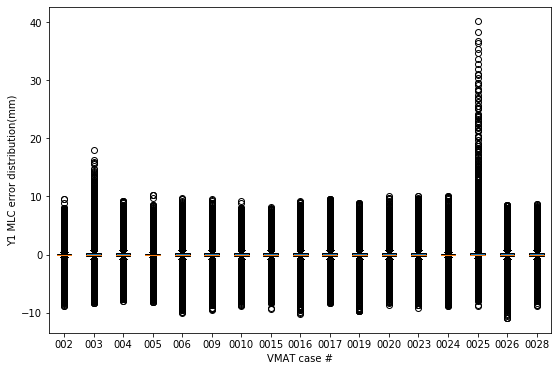

In [12]:
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(t1,patch_artist=True)
ax.set_xticklabels(pt_id)
ax.set_xlabel('VMAT case #')
ax.set_ylabel('Y1 MLC error distribution(mm)')
plt.show()

In [13]:
Y1_max_err = [np.max(np.abs(mlc_position_err[key]['Y1_mlc_err'])) for key in pt_id]
Y2_max_err = [np.max(np.abs(mlc_position_err[key]['Y2_mlc_err'])) for key in pt_id]

In [14]:
Y1_mean_err = [np.mean(np.abs(mlc_position_err[key]['Y1_mlc_err'])) for key in pt_id]
Y2_mean_err = [np.mean(np.abs(mlc_position_err[key]['Y2_mlc_err'])) for key in pt_id]

In [15]:
Z1 = np.polyfit(np.array(Y1_max_err),np.array(diff_max),1)
P1 = np.poly1d(Z1)
XP1 = np.linspace(0, 45, 100)

Z2 = np.polyfit(np.array(Y2_max_err),np.array(diff_max),1)
P2 = np.poly1d(Z2)
XP2 = np.linspace(0, 45, 100)

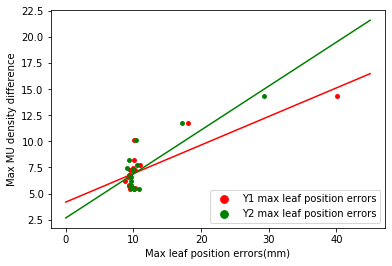

In [16]:
plt.figure
plt.scatter(Y1_max_err,diff_max,c='red',marker='o',s = 15,label='Y1 max leaf position errors')
plt.plot(XP1,P1(XP1),'r')
plt.scatter(Y2_max_err,diff_max,c='green',marker='o',s = 15,label='Y2 max leaf position errors')
plt.plot(XP2,P2(XP2),'g')
plt.xlabel('Max leaf position errors(mm)')
plt.ylabel('Max MU density difference')
plt.legend(loc="lower right", markerscale=2., scatterpoints=1, fontsize=10)
plt.show()

In [17]:
data = np.zeros([3,len(pt_id)])
for i,item in enumerate(pt_id):
    data[0,i] = diff_max[i] # max mu_density difference
    data[1,i] = Y1_max_err[i] # max mlc y1 leaf errors
    data[2,i] = Y2_max_err[i] # max mlc y2 leaf errors
df = pd.DataFrame(data, columns=pt_id, index = ['max mu density difference','mlc y1 leaf max errors(mm)','mlc y2 max errors(mm)'])  
df.head()

,002,003,004,005,006,009,0010,0015,0016,0017,0019,0020,0023,0024,0025,0026,0028
max mu density difference,5.423316,11.752032,5.837944,7.264281,7.478745,7.263248,6.545392,5.674703,5.484829,6.750525,5.489449,5.410537,8.224977,10.134395,14.313549,7.726508,6.197941
mlc y1 leaf max errors(mm),9.500000,18.000000,9.300000,10.300000,10.000000,9.500000,9.200000,9.300000,10.200000,9.500000,9.700000,10.100000,10.100000,10.100000,40.100000,10.900000,8.800000
mlc y2 max errors(mm),10.100000,17.200000,9.600000,10.000000,9.100000,10.000000,9.700000,9.500000,9.600000,9.300000,10.000000,10.800000,9.400000,10.400000,29.300000,10.500000,9.700000


### Clinical case (to explore if the mlc position error goes to 10mm)

In [3]:
# clinical case
clinic_path = 'C:\\GitFolder\\VMAT-QA-metrics\\MU intensity\\MonacoHDMLC.trf'
clinic = pymedphys.trf.read(clinic_path)
clinic = clinic[1]

In [4]:
Y1_mlc_err_cli,Y2_mlc_err_cli = [],[]
for i in range(80):
    Y1_mlc_err_cli = Y1_mlc_err_cli + list(clinic['Y1 Leaf '+str(i+1)+'/Positional Error (mm)'])
    Y2_mlc_err_cli = Y2_mlc_err_cli + list(clinic['Y2 Leaf '+str(i+1)+'/Positional Error (mm)'])

In [6]:
# mean max mlc position errors for clinical cases
print('The clinical maximum mlc position errors Y1:{}mm, Y2:{}mm'.format(np.max(Y1_mlc_err_cli),np.max(Y2_mlc_err_cli)))

The clinical maximum mlc position errors Y1:3.8mm, Y2:2.7mm


In [21]:
# mean max mlc position errors for emulator
print('The emulator mean maximum mlc position errors Y1:{}mm, Y2:{}mm'.format(round(np.mean(Y1_max_err),3),round(np.mean(Y2_max_err),3)))

The emulator mean maximum mlc position errors Y1:12.035mm, Y2:11.424mm


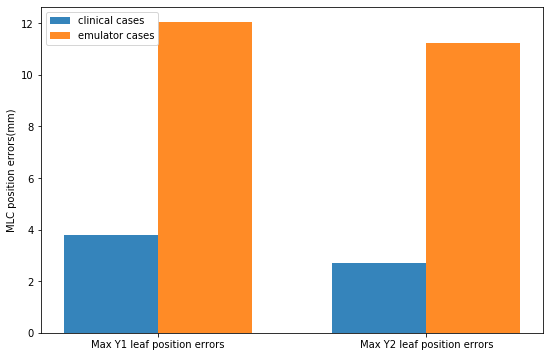

In [33]:
plt.figure(figsize=(9,6))
x =[1.0,2.0]
y1 = [3.8,2.7]
y2 = [12.04,11.24]
plt.bar(x, y1, alpha=0.9, width = 0.35,label='clinical cases')
plt.bar([1.35,2.35], y2, alpha=0.9, width = 0.35,label='emulator cases', lw=1)
plt.legend(loc="upper left")
plt.xticks([1+0.35/2,2+0.35/2], ['Max Y1 leaf position errors','Max Y2 leaf position errors'])
plt.ylabel('MLC position errors(mm)')
plt.show()

In [48]:
# len(S1),len(S2)-len(S1),len(S3),len(S)

(58570, 12675, 355, 71600)

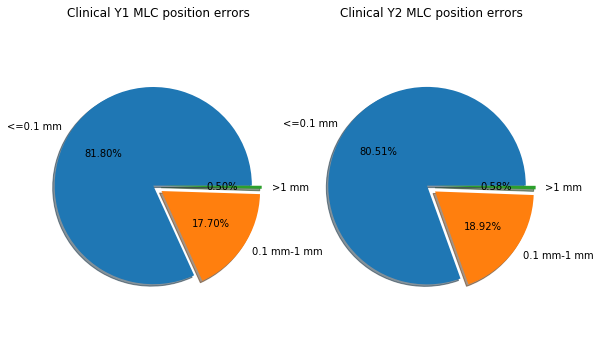

In [62]:
S = np.abs(Y1_mlc_err_cli)
S1 = S[S<=0.1]
S2 = S[S<=1]
S3 = S[S>1]
x1 = [100*len(S1)/len(S),100*(len(S2)-len(S1))/len(S),100*len(S3)/len(S)]

S = np.abs(Y2_mlc_err_cli)
S1 = S[S<=0.1]
S2 = S[S<=1]
S3 = S[S>1]
x2 = [100*len(S1)/len(S),100*(len(S2)-len(S1))/len(S),100*len(S3)/len(S)]

labels = ['<=0.1 mm','0.1 mm-1 mm','>1 mm']
#饼图分离
explode = (0,0.1,0.1)
#设置阴影效果
plt.figure(figsize=(9,6))
plt.subplot(1,2,1)
plt.pie(x1,labels=labels,autopct='%3.2f%%',explode=explode,shadow=True)
#设置x,y的刻度一样，使其饼图为正圆
plt.axis('equal')
plt.title('Clinical Y1 MLC position errors')

plt.subplot(1,2,2)
plt.pie(x2,labels=labels,autopct='%3.2f%%',explode=explode,shadow=True)
#设置x,y的刻度一样，使其饼图为正圆
plt.axis('equal')
plt.title('Clinical Y2 MLC position errors')

plt.show()

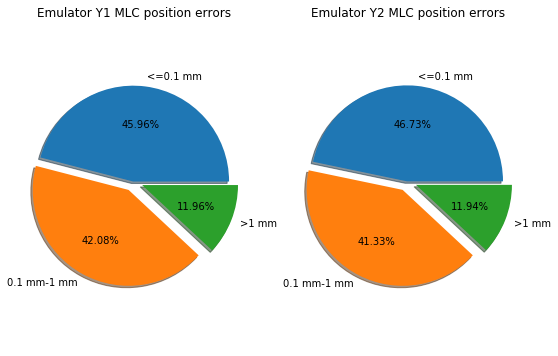

In [63]:
Y1_total_err,Y2_total_err = [],[]
for key in pt_id:
    Y1_total_err = Y1_total_err + mlc_position_err[key]['Y1_mlc_err']
    Y2_total_err = Y2_total_err + mlc_position_err[key]['Y2_mlc_err']

S = np.abs(Y1_total_err)
S1 = S[S<=0.1]
S2 = S[S<=1]
S3 = S[S>1]
x1 = [100*len(S1)/len(S),100*(len(S2)-len(S1))/len(S),100*len(S3)/len(S)]
    
S = np.abs(Y2_total_err)
S1 = S[S<=0.1]
S2 = S[S<=1]
S3 = S[S>1]
x2 = [100*len(S1)/len(S),100*(len(S2)-len(S1))/len(S),100*len(S3)/len(S)]    
    
    
labels = ['<=0.1 mm','0.1 mm-1 mm','>1 mm']
#饼图分离
explode = (0,0.1,0.1)
#设置阴影效果
plt.figure(figsize=(9,6))
plt.subplot(1,2,1)
plt.pie(x1,labels=labels,autopct='%3.2f%%',explode=explode,shadow=True)
#设置x,y的刻度一样，使其饼图为正圆
plt.axis('equal')
plt.title('Emulator Y1 MLC position errors')

plt.subplot(1,2,2)
plt.pie(x2,labels=labels,autopct='%3.2f%%',explode=explode,shadow=True)
#设置x,y的刻度一样，使其饼图为正圆
plt.axis('equal')
plt.title('Emulator Y2 MLC position errors')

plt.show()

### Show the MLC position in apertures

In [58]:
mlc_position_err_new = {item:{} for item in pt_id}
for item in pt_id:
    SS1 = 40+np.ceil(np.array(jaw_position_err[item]['JAW1_position'])/5)
    SS2 = 40-np.ceil(np.array(jaw_position_err[item]['JAW2_position'])/5)
    flag = np.zeros([len(SS1),80])
    for i in range(len(SS1)):
        flag[i,int(SS2[i]):int(SS1[i])] = 1
    flag_ =[]
    for i in range(len(SS1)):
        flag_ = flag_ + list(flag[i,:])
    mlc_position_err_new[item]['Y1_mlc_err'] = np.array(mlc_position_err[item]['Y1_mlc_err'])* np.array(flag_)
    mlc_position_err_new[item]['Y2_mlc_err'] = np.array(mlc_position_err[item]['Y2_mlc_err'])* np.array(flag_)

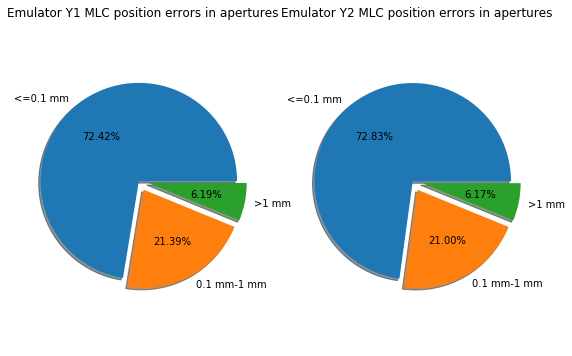

In [65]:
Y1_total_err_,Y2_total_err_ = [],[]
for key in pt_id:
    Y1_total_err_ = Y1_total_err_ + list(mlc_position_err_new[key]['Y1_mlc_err'])
    Y2_total_err_ = Y2_total_err_ + list(mlc_position_err_new[key]['Y2_mlc_err'])
    
S = np.abs(Y1_total_err_)
S1 = S[S<=0.1]
S2 = S[S<=1]
S3 = S[S>1]
x1 = [100*len(S1)/len(S),100*(len(S2)-len(S1))/len(S),100*len(S3)/len(S)]
    
S = np.abs(Y2_total_err_)
S1 = S[S<=0.1]
S2 = S[S<=1]
S3 = S[S>1]
x2 = [100*len(S1)/len(S),100*(len(S2)-len(S1))/len(S),100*len(S3)/len(S)]    
    
    
labels = ['<=0.1 mm','0.1 mm-1 mm','>1 mm']
#饼图分离
explode = (0,0.1,0.1)
#设置阴影效果
plt.figure(figsize=(9,6))
plt.subplot(1,2,1)
plt.pie(x1,labels=labels,autopct='%3.2f%%',explode=explode,shadow=True)
#设置x,y的刻度一样，使其饼图为正圆
plt.axis('equal')
plt.title('Emulator Y1 MLC position errors in apertures')

plt.subplot(1,2,2)
plt.pie(x2,labels=labels,autopct='%3.2f%%',explode=explode,shadow=True)
#设置x,y的刻度一样，使其饼图为正圆
plt.axis('equal')
plt.title('Emulator Y2 MLC position errors in apertures')

plt.show()

<font color='blue'>Question1: How to define if these mlc position error is inside or outside aperture ?</font>

<font color='blue'>Question2: How to understand the MLC positional errors in trf files ?</font>

<font color='blue'>Question3: How to compare the MLC positional errors between trf and DICOM files ?</font>

<font color='blue'>Question4: How much effect would this positional errors cause on dose distribution in patient?</font>

### Determine the MLC position errors occured inside aperture

In [7]:
## 0025 testing cases
import pymedphys
import numpy as np
import pydicom
DCM_path = 'D:\\VM Settings\\XHTOMODATA RAW\\002\\002_VMATQATEST.dcm'
TRF_path = 'D:\\VM Settings\\XHTOMODATA RAW\\TRF\\002.trf'

In [8]:
def extract_DICOM(DICOM_name,TPS_name,deliver):
    '''
       This function was used for extracting DICOM file
    '''

    import pydicom 
    import os
    dcm = pydicom.read_file(DICOM_name,force=True)
    # TPS = 'Monaco'
    mu_density = {'Gantry':[],'MLC':[],'JAW':[],'MU':[],'Absolute_MU':[]}

    for i in range(len(dcm.BeamSequence)):

        mu_density['Absolute_MU'].append(float(dcm.FractionGroupSequence[0].ReferencedBeamSequence[i].BeamMeterset))

        for j in range(len(dcm.BeamSequence[i].ControlPointSequence)):
            
            if deliver == 'dMLC':
                mu_density['Gantry'].append(int(dcm.BeamSequence[i].ControlPointSequence[0].GantryAngle))
            else:
                mu_density['Gantry'].append(int(dcm.BeamSequence[i].ControlPointSequence[j].GantryAngle))

            if TPS_name == 'Pinnacle':
    #             print(i,j)
                MU = float(dcm.BeamSequence[i].ControlPointSequence[j].CumulativeMetersetWeight)*float(mu_density['Absolute_MU'][i])/100
    #             print('MU is {}'.format(MU))
                mu_density['MU'].append(MU)
                if len(dcm.BeamSequence[i].ControlPointSequence[j].BeamLimitingDevicePositionSequence) == 3:
                    mu_density['MLC'].append(dcm.BeamSequence[i].ControlPointSequence[j].BeamLimitingDevicePositionSequence[2].LeafJawPositions)
                    mu_density['JAW'].append(dcm.BeamSequence[i].ControlPointSequence[j].BeamLimitingDevicePositionSequence[1].LeafJawPositions)
                else:
                    mu_density['MLC'].append(dcm.BeamSequence[i].ControlPointSequence[j].BeamLimitingDevicePositionSequence[0].LeafJawPositions)
                    mu_density['JAW'].append([None,None])
                    print('it has no jaw positions')
                    print('This is {}th beam {}th control point'.format(i+1,j+1))
                    print('MU is {}'.format(MU))
            elif TPS_name == 'Monaco':
                MU = float(dcm.BeamSequence[i].ControlPointSequence[j].CumulativeMetersetWeight)
                mu_density['MU'].append(MU)
                mu_density['MLC'].append(dcm.BeamSequence[i].ControlPointSequence[j].BeamLimitingDevicePositionSequence[1].LeafJawPositions)
                mu_density['JAW'].append(dcm.BeamSequence[i].ControlPointSequence[j].BeamLimitingDevicePositionSequence[0].LeafJawPositions)


    #further clearning
    PLAN = {key:[] for key in mu_density.keys()}
    PLAN['MU_absolute'] = mu_density['Absolute_MU']
    for i,item in enumerate(mu_density['MU']):
        if i==0:
            PLAN['JAW'].append(mu_density['JAW'][i])
            PLAN['MU'].append(mu_density['MU'][i])
            PLAN['Gantry'].append(mu_density['Gantry'][i])
            PLAN['MLC'].append(mu_density['MLC'][i])
        else:
            if mu_density['MU'][i] != mu_density['MU'][i-1]:
                PLAN['JAW'].append(mu_density['JAW'][i])
                PLAN['MU'].append(mu_density['MU'][i])
                PLAN['Gantry'].append(mu_density['Gantry'][i])
                PLAN['MLC'].append(mu_density['MLC'][i])
                
    return PLAN

In [99]:
PLAN = extract_DICOM(DCM_path,'Monaco','VMAT')

In [61]:
MU = np.array(PLAN['MU'])*PLAN['MU_absolute']

In [9]:
Delivery = pymedphys.trf.read(TRF_path)
Deliver = Delivery[1]
Deliver_ = Deliver[Deliver['Linac State/Actual Value (None)'] == 'Radiation On']
TRF = {'Gantry':[],'MLC':[],'JAW':[],'MU':[],'Absolute_MU':[]}

In [79]:
CP2 = Deliver_[Deliver_['Control point/Actual Value (None)'] == 2.0]

In [103]:
CP1['Step Gantry/Scaled Actual (deg)'][1:]

0.96   -180.1
1.00   -180.1
1.04   -180.1
1.08   -180.1
1.12   -180.1
        ...  
5.48   -178.7
5.52   -178.5
5.56   -178.5
5.60   -178.5
5.64   -178.2
Name: Step Gantry/Scaled Actual (deg), Length: 118, dtype: float64

In [67]:
CP1.tail(1)

,unknown1,unknown2,unknown3,unknown4,Control point/Actual Value (None),Energy Cal Block/Set (None),Linac State/Actual Value (None),Actual Dose Rate/Actual Value (Mu/min),Step Dose/Actual Value (Mu),Dose/Raw value (1/64th Mu),...,Y1 Leaf 71/Positional Error (mm),Y1 Leaf 72/Positional Error (mm),Y1 Leaf 73/Positional Error (mm),Y1 Leaf 74/Positional Error (mm),Y1 Leaf 75/Positional Error (mm),Y1 Leaf 76/Positional Error (mm),Y1 Leaf 77/Positional Error (mm),Y1 Leaf 78/Positional Error (mm),Y1 Leaf 79/Positional Error (mm),Y1 Leaf 80/Positional Error (mm)
5.64,40219,51169,371,0,1.0,1,Radiation On,318,9.5,609,...,0.2,0.3,0.3,0.3,0.3,0.2,0.2,0.4,0.2,0.2


### Plan complexity metrics correlation with mu difference

In [74]:
# load the complexity metrics
import pandas as pd
CI = pd.read_csv('C:/GitFolder/RL-Application-in-TPS/AUTO-PLANNING/AutoTemplateTuning/projects/sequencing prediction/Metrics_table.csv')

In [6]:
MCS = CI.iloc[8]

In [8]:
PI = CI.iloc[4]

In [75]:
Table_Index = CI.iloc[:,1:].T

In [108]:
Table_Index.head()

,Edge metric (EM),Union aperture area (UAA) cm^2,Plan normalized MU (PMU),Plan modulation (PM),Plan irregularity (PI),Plan area (PA),Aperture area variability (AAV),Leaf sequence variability (LSV),Modulation complexity score (MCS),Mean asymmetry distance (MAD) mm,...,Modulation index for leaf acceleration (f=0.2),Modulation index for leaf acceleration (f=0.5),Modulation index for leaf acceleration (f=1),Modulation index for leaf acceleration (f=2),Modulation index for total modulation(f=0.2),Modulation index for total modulation(f=0.5),Modulation index for total modulation(f=1),Modulation index for total modulation(f=2),SSIM,PSNR
VMAT_PLN_INFO_002,0.198521,386.145,668.083496,0.811535,10.401435,72.774679,0.548836,0.997520,0.547501,34.905054,...,17.820733,37.582533,61.954600,88.009000,31.566747,66.776449,110.413021,156.830509,0.998797,53.721725
VMAT_PLN_INFO_003,0.107757,366.830,628.493542,0.800864,8.641971,73.049079,0.552773,1.000005,0.552764,32.492981,...,18.074679,37.404083,58.929541,80.390688,NaN,NaN,NaN,NaN,0.998776,53.384198
VMAT_PLN_INFO_004,0.146964,376.515,597.277444,0.801396,8.347365,74.777252,0.561806,0.996400,0.560179,35.130708,...,17.258633,36.003741,58.448777,82.923237,28.880799,60.517826,98.884991,141.524025,0.998876,54.274395
VMAT_PLN_INFO_005,0.154749,251.885,498.851429,0.766118,7.533832,58.911393,0.552405,1.006007,0.555323,22.982913,...,14.185255,29.115474,46.820219,66.064745,22.757782,46.934413,75.748035,107.162412,0.999325,55.797472
VMAT_PLN_INFO_006,0.180953,419.430,594.719793,0.789587,10.258958,88.253721,0.564541,1.001054,0.565024,35.786075,...,18.969481,39.846948,65.413571,93.491364,30.616838,64.653916,106.684861,153.136079,0.998403,52.528274


In [87]:
col = list(CI.iloc[:,0])

In [86]:
Table_Index.columns = col

In [88]:
Table_Index.head()

,Edge metric (EM),Union aperture area (UAA) cm^2,Plan normalized MU (PMU),Plan modulation (PM),Plan irregularity (PI),Plan area (PA),Aperture area variability (AAV),Leaf sequence variability (LSV),Modulation complexity score (MCS),Mean asymmetry distance (MAD) mm,...,Modulation index for leaf speed (f=1),Modulation index for leaf speed (f=2),Modulation index for leaf acceleration (f=0.2),Modulation index for leaf acceleration (f=0.5),Modulation index for leaf acceleration (f=1),Modulation index for leaf acceleration (f=2),Modulation index for total modulation(f=0.2),Modulation index for total modulation(f=0.5),Modulation index for total modulation(f=1),Modulation index for total modulation(f=2)
VMAT_PLN_INFO_002,0.198521,386.145,668.083496,0.811535,10.401435,72.774679,0.548836,0.997520,0.547501,34.905054,...,51.838940,74.449669,17.820733,37.582533,61.954600,88.009000,31.566747,66.776449,110.413021,156.830509
VMAT_PLN_INFO_003,0.107757,366.830,628.493542,0.800864,8.641971,73.049079,0.552773,1.000005,0.552764,32.492981,...,51.020548,70.389680,18.074679,37.404083,58.929541,80.390688,NaN,NaN,NaN,NaN
VMAT_PLN_INFO_004,0.146964,376.515,597.277444,0.801396,8.347365,74.777252,0.561806,0.996400,0.560179,35.130708,...,48.673286,69.627143,17.258633,36.003741,58.448777,82.923237,28.880799,60.517826,98.884991,141.524025
VMAT_PLN_INFO_005,0.154749,251.885,498.851429,0.766118,7.533832,58.911393,0.552405,1.006007,0.555323,22.982913,...,39.516304,56.111522,14.185255,29.115474,46.820219,66.064745,22.757782,46.934413,75.748035,107.162412
VMAT_PLN_INFO_006,0.180953,419.430,594.719793,0.789587,10.258958,88.253721,0.564541,1.001054,0.565024,35.786075,...,55.930323,80.649742,18.969481,39.846948,65.413571,93.491364,30.616838,64.653916,106.684861,153.136079


In [89]:
Table_Index['SSIM'] = np.array(SSIM_mean).T

In [90]:
Table_Index['PSNR'] = np.array(PSNR).T

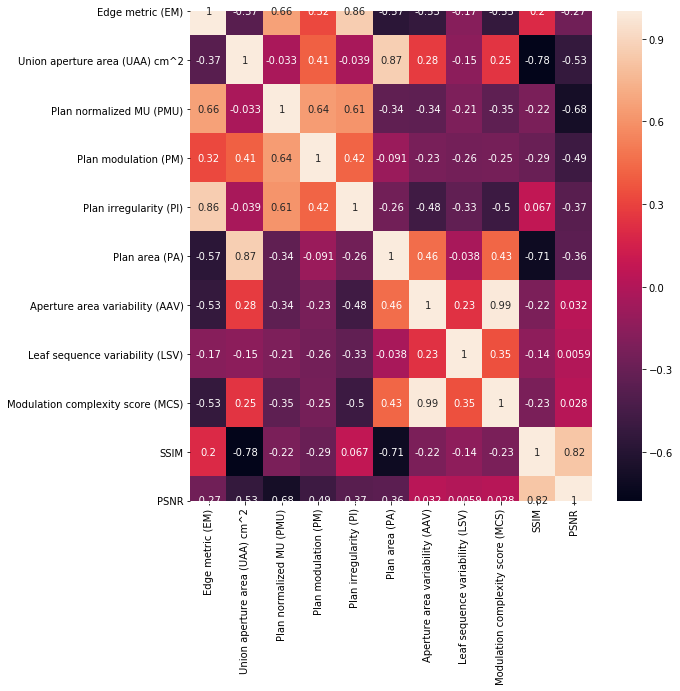

In [100]:
import seaborn as sns

import matplotlib.pyplot as plt

# taking all rows but only 6 columns
df_small = Table_Index.iloc[:,[0,1,2,3,4,5,6,7,8,-2,-1]]

correlation_mat = df_small.corr()
plt.figure(figsize=(9,9))
sns.heatmap(correlation_mat, annot = True)

plt.show()

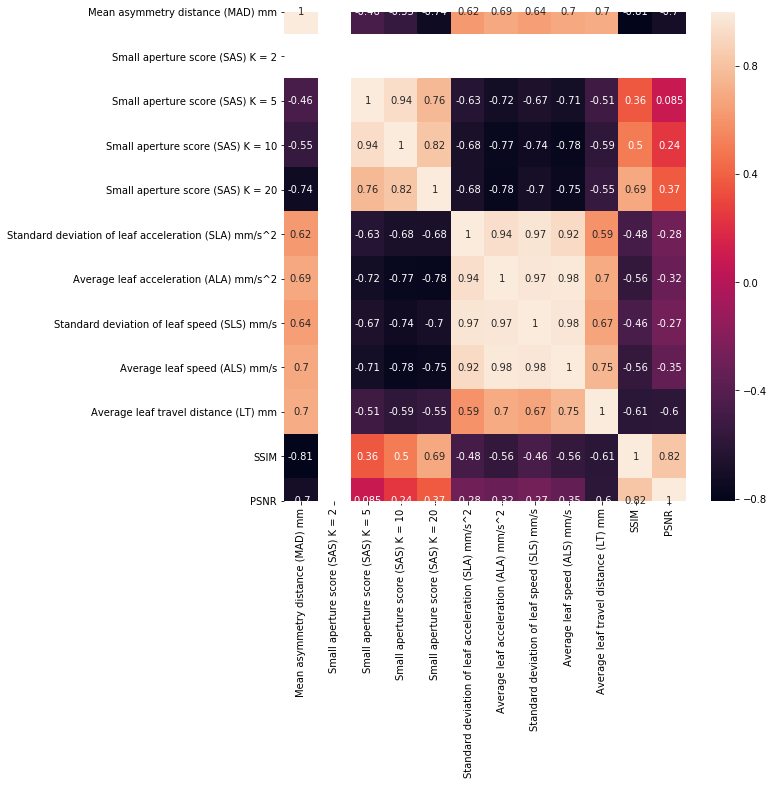

In [106]:
import seaborn as sns

import matplotlib.pyplot as plt

# taking all rows but only 6 columns
df_small = Table_Index.iloc[:,[9,10,11,12,13,14,15,16,17,18,-2,-1]]

correlation_mat = df_small.corr()
plt.figure(figsize=(9,9))
sns.heatmap(correlation_mat, annot = True)

plt.show()

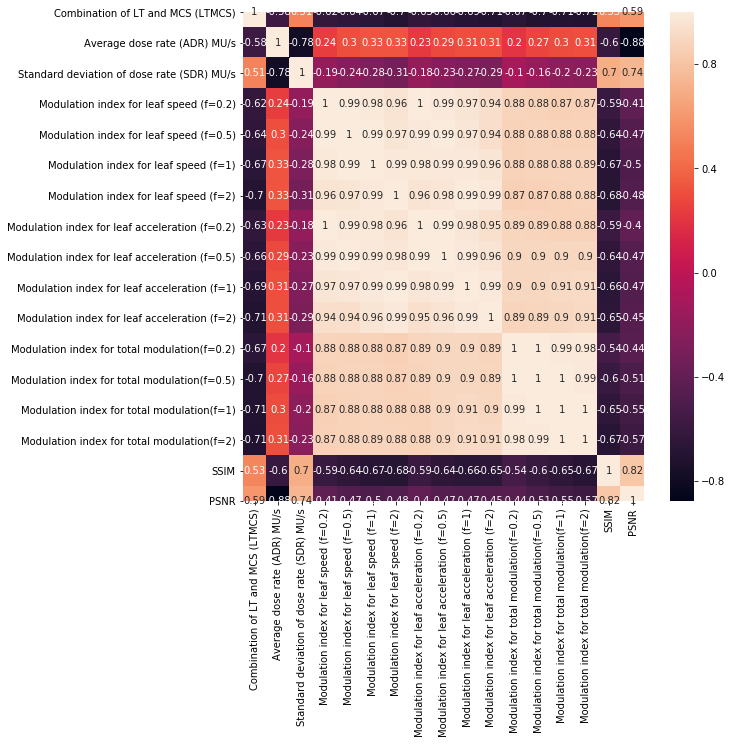

In [107]:
import seaborn as sns

import matplotlib.pyplot as plt

# taking all rows but only 6 columns
df_small = Table_Index.iloc[:,19:]

correlation_mat = df_small.corr()
plt.figure(figsize=(9,9))
sns.heatmap(correlation_mat, annot = True)

plt.show()

###  Maximum Dose Rate from Log files